In [1]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm
import torch
import yaml

from models import MultiStage_VAE
from utils import get_dataloader, Annealizer
import yaml

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [93]:
BS = 256
dataset = torchvision.datasets.MNIST(root = '.',download = False, transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    transforms.Normalize(mean = 0.5, std =0.5)]))
dataloader = DataLoader(dataset,batch_size=BS, shuffle=True)

In [94]:
with open('./parameters/multistage_vae_params.yaml', 'rb') as f:
    config = yaml.safe_load(f)

size_second_stage = 3
model = MultiStage_VAE(config['model parameters'], size_second_stage)
model = model.to(device)

In [95]:
x = next(iter(dataloader))[0]
out, x_first, mu, logvar = model(x.to(device))
out.shape, x_first.shape, model.vae.decoder_output_pad

(torch.Size([256, 1, 28, 28]), torch.Size([256, 1, 28, 28]), [0, 1, 1])

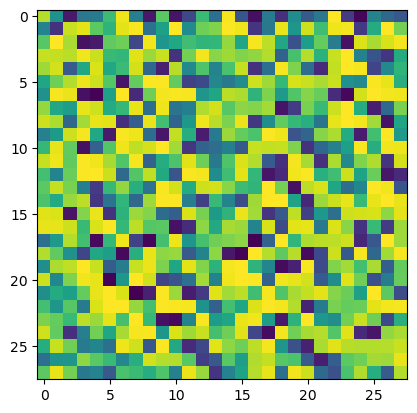

In [96]:
imshow((out/2+.5).detach().cpu()[0].permute(1,2,0).numpy())

In [97]:
def loss_function(x, x_final, x_pred, mu, logvar, kl_weight):
    loss_mse = F.mse_loss(x, x_pred)
    loss_kl = torch.mean(0.5 * torch.sum(1-mu**2 - logvar.exp() +logvar, dim = 1), dim = 0)
    loss_l1 = F.l1_loss(x, x_final)
    loss = loss_mse - kl_weight * loss_kl + loss_l1
    
    return loss, loss_mse.item(), -loss_kl.item(), loss_l1.item()

In [112]:
lr = 1e-4
kl_weight = 0.0005
optimizer = torch.optim.AdamW(model.parameters(), lr = lr, betas = (0.5, 0.999))
epochs = 10

lr_decay_epochs = 1
lr_rate_decay = 0.5



In [113]:
losses = []
losses_mse = []
losses_l1 = []


for i in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    for x, _ in pbar:
        x = x.to(device)
        optimizer.zero_grad()

        out, x_first, mu, logvar = model(x)

        loss, loss_mse, loss_kl, loss_l1 = loss_function(x, out, x_first, mu, logvar, kl_weight)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        losses_mse.append(loss_mse)
        losses_l1.append(loss_l1)
        pbar.set_description('Loss: %.3f, loss MSE: %.3f, loss L1: %.3f' % (loss.item(),loss_mse, loss_l1 ))


Loss: 0.142, loss MSE: 0.038, loss L1: 0.071: 100%|██████████| 235/235 [00:19<00:00, 11.99it/s]


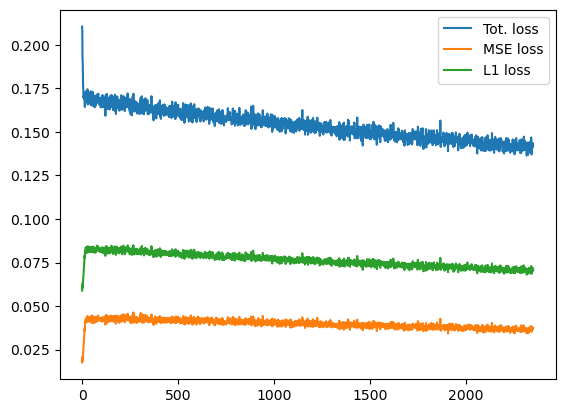

In [114]:
plot(losses[:], label = 'Tot. loss')
plot(losses_mse[:], label = 'MSE loss')
plot(losses_l1[:], label = 'L1 loss')
legend()

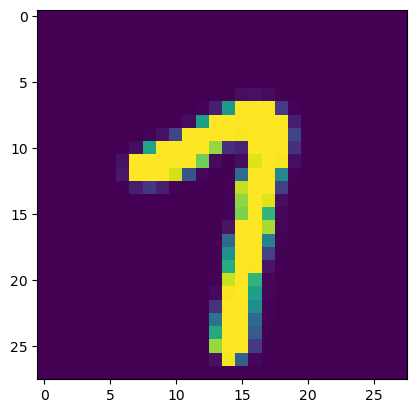

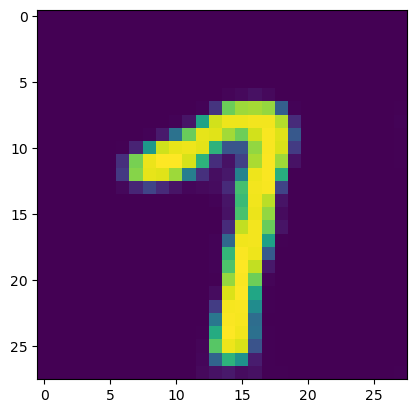

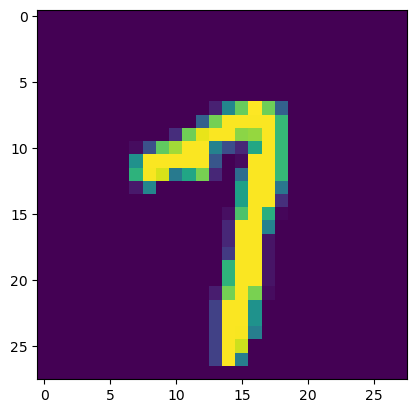

In [115]:
imshow(out[0].detach().cpu().permute(1,2,0).numpy())
show()
imshow(x_first[0].detach().cpu().permute(1,2,0).numpy())
show()
imshow(x[0].detach().cpu().permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


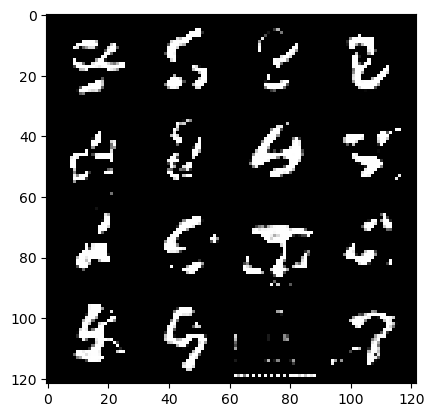

In [118]:
x_samp = model.sample(16)
grid = torchvision.utils.make_grid(x_samp, nrow = 4)
imshow(grid.cpu().permute(1,2,0).numpy())

In [87]:
#torchvision.utils.save_image(grid, './output_images/multistageMNIST_sampled.png')

In [88]:
#torch.save(model.state_dict(), './model_saves/multistageVAE_MNIST.pth')
#model.load_state_dict(torch.load('./model_saves/multistageVAE_MNIST.pth'))

In [89]:
test_dataset = torchvision.datasets.MNIST(root = '.',download = False, train = False, transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()]))
#Important no Normalize since we want image between 0, 1 to get the targets as int [0, ..., 255]
test_dataloader = DataLoader(test_dataset,batch_size=BS, shuffle=True)

In [109]:
test_losses,  test_losses_mse, test_losses_kl, test_losses_l1 = [], [], [], []
with torch.no_grad():
    for x, _ in test_dataloader:
        out, x_first, mu, logvar = model(x.to(device))
        loss, loss_mse, loss_kl, loss_l1 = loss_function(x.to(device), out, x_first, mu, logvar, kl_weight)
        test_losses.append(loss.item()), test_losses_mse.append(loss_mse), test_losses_kl.append(loss_kl), test_losses_l1.append(loss_l1)



In [110]:
mean(test_losses),  mean(test_losses_mse), kl_weight*mean(test_losses_kl), mean(test_losses_l1)

(1.6951925098896026,
 0.8315202191472053,
 0.006689918956756592,
 0.8569823682308197)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


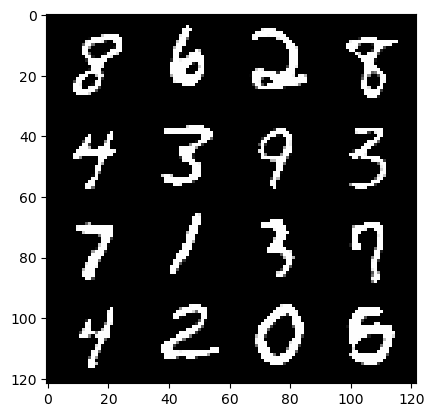

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


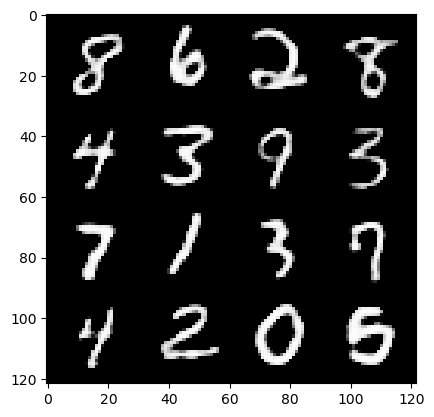

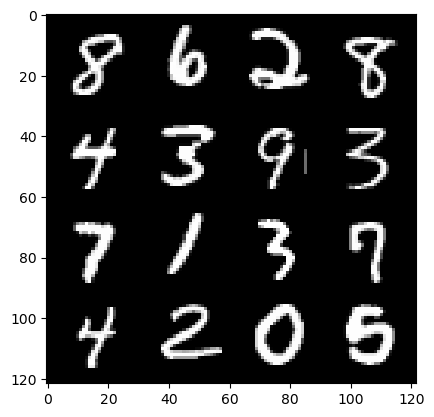

In [111]:
for y in (out, x_first, x):
    grid = torchvision.utils.make_grid(y, nrow = 4)
    imshow(grid.cpu().permute(1,2,0).numpy())
    show()

#### We see the second part makes output far less blurry, regarding the sampling, it leads to sub optimal outputs.

It should be more interesting on AFHQ dataset.

# AFHQ

In [91]:
from utils import get_dataloader

BS = 64
img_size = 128
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
dataloader, classes, unnormalize = get_dataloader(img_size=img_size,batch_size=BS, animals = ['cat'] ,norm_values=(mean, std))

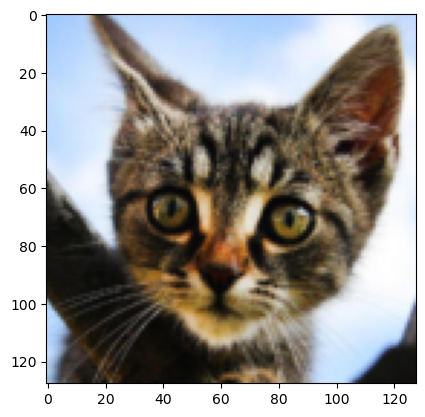

In [5]:
x = next(iter(dataloader))[0]
imshow(unnormalize(x)[0].permute(1,2,0).numpy())

In [14]:
with open('./parameters/multistageVAE_AFHQ_params.yaml', 'rb') as f:
    config = yaml.safe_load(f)

size_second_stage = 3
model = MultiStage_VAE(config['model parameters'], size_second_stage=size_second_stage)
model.to(device)

MultiStage_VAE(
  (vae): VAE_complex(
    (init_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder_blocks): ModuleList(
      (0): VAE_Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

In [15]:
x = next(iter(dataloader))[0]

In [16]:
from torchview import draw_graph

model_graph = draw_graph(model, input_data = x.to(device))
#model_graph.visual_graph

In [17]:
out = model(x.to(device))

In [32]:
lr = 1e-4
kl_weight =  0.00025
optimizer = torch.optim.AdamW(model.parameters(), lr = lr, betas = (0.5, 0.999))

In [33]:
losses = []
losses_mse = []
losses_l1 = []


epochs = 30
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    for x, _ in pbar:
        x = x.to(device)
        optimizer.zero_grad()

        out, x_first, mu, logvar = model(x)

        loss, loss_mse, loss_kl, loss_l1 = loss_function(x, out, x_first, mu, logvar, kl_weight)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        losses_mse.append(loss_mse)
        losses_l1.append(loss_l1)
        pbar.set_description('Loss: %.3f, loss MSE: %.3f, loss L1: %.3f' % (loss.item(),loss_mse, loss_l1 ))

    

Loss: 0.852, loss MSE: 0.344, loss L1: 0.459:  44%|████▍     | 36/81 [00:25<00:31,  1.42it/s]


KeyboardInterrupt: 

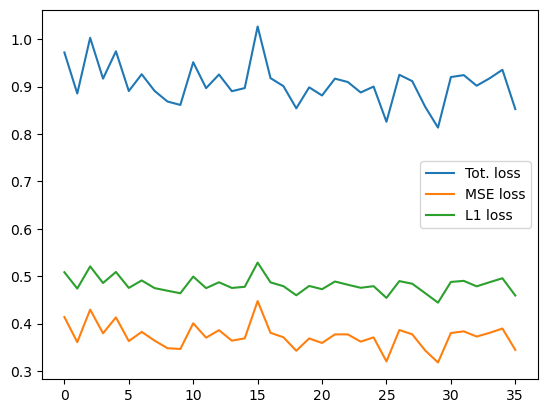

In [35]:
plot(losses, label = 'Tot. loss')
plot(losses_mse, label  ='MSE loss')
plot(losses_l1, label = 'L1 loss')
legend()

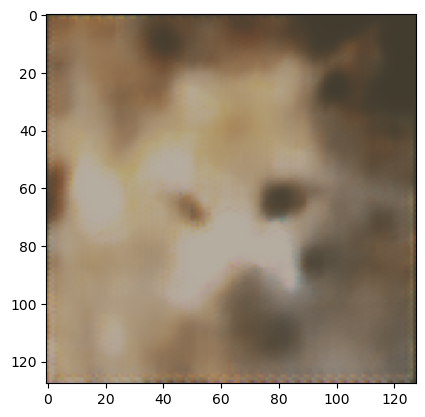

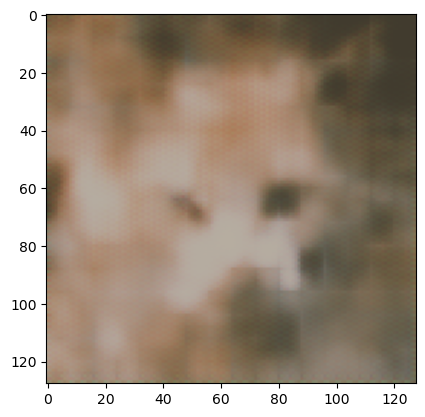

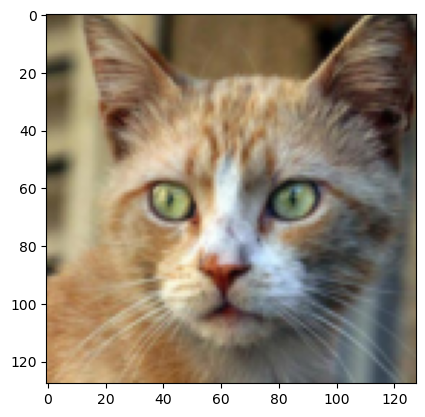

In [37]:
imshow(unnormalize(out)[20].detach().cpu().permute(1,2,0).numpy())
show()
imshow(unnormalize(x_first)[20].detach().cpu().permute(1,2,0).numpy())
show()
imshow(unnormalize(x)[20].detach().cpu().permute(1,2,0).numpy())

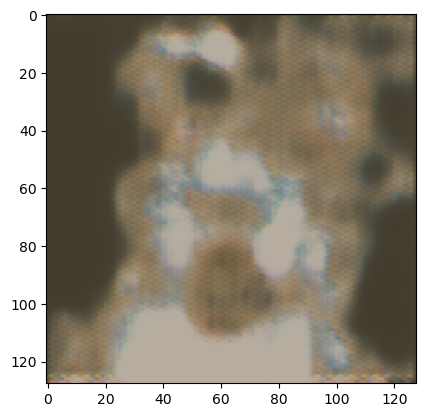

In [40]:
samp = model.sample(1)
imshow(unnormalize(samp)[0].cpu().permute(1,2,0).numpy())